# Capstone Project - Introduction and Bussiness Problem - What should we do in Madrid?

### Introduction

Madrid is one of the most visited cities in Spain, in 2018 has received 4.100.099 spanish tourist and 5.176.908 foreign tourists, becoming the most visited spanish city by Spanish tourists and the second most visited spanish city by foreign tourists behind of Barcelona (data taken from INE - Spanish Statistics National Institute).
But despite of that, even with this huge amount of tourists, peopli still dont know where go to eat, what should they visit... So for this i would like to create this project, to extract one hundred Madrid venues via Foursquare API and see which venue is the most popular of each categorie and create clusters.

### Business Problem

As i said before, tourists can be confuse because of the huge amount of restaurants, pubs, monuments... What Madrid has, so with this analyze i will help them to decide what shoul they do in this beautiful city. 

### Data

For this project i will extract the data from Foursquare API and im gonna have this columns:

 * Name
 * Id
 * Category
 * Clas Category
 * Latitud
 * Longitude
 * Likes
 * Category per likes 
 * Cluster label

## Libraries
Here im going to import al the libraries that im gonna use

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 
from IPython.display import Image 
from IPython.core.display import HTML 
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
import requests 
from pandas.io.json import json_normalize 

Solving environment: ...working... done

# All requested packages already installed.



WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.


Solving environment: ...working... done

# All requested packages already installed.



WARNING conda.base.context:use_only_tar_bz2(632): Conda is constrained to only using the old .tar.bz2 file format because you have conda-build installed, and it is <3.18.3.  Update or remove conda-build to get smaller downloads and faster extractions.


## Foursquare data extraction

### First step
In this step im going to get the coordinates for Madrid

In [178]:
address = 'Madrid, Spain'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Madrid are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid are 40.4167047, -3.7035825.


### Second step
And know lets configure the parameters for the Foursquare API

In [179]:
CLIENT_ID = 'OHPCOIAFK55ID1LVK5OOGYTBINAL2PYT5WTZHSRJ0LOGCNJN' # your Foursquare ID
CLIENT_SECRET = 'V2BA1AXCUM1UWDIDXA0POYLGIFFECJRCLXLBB2ZVAII5NCEK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OHPCOIAFK55ID1LVK5OOGYTBINAL2PYT5WTZHSRJ0LOGCNJN
CLIENT_SECRET:V2BA1AXCUM1UWDIDXA0POYLGIFFECJRCLXLBB2ZVAII5NCEK


### Third step
In this step im creating the API url

In [180]:
LIMIT = 100 
radius = 1000 

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=OHPCOIAFK55ID1LVK5OOGYTBINAL2PYT5WTZHSRJ0LOGCNJN&client_secret=V2BA1AXCUM1UWDIDXA0POYLGIFFECJRCLXLBB2ZVAII5NCEK&v=20180605&ll=40.4167047,-3.7035825&radius=1000&limit=100'

### Fourth step
And finally i want to get the results from Foursquare

In [181]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d1927530d2be7002c40b00e'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Sol',
  'headerFullLocation': 'Sol, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 243,
  'suggestedBounds': {'ne': {'lat': 40.42570470900001,
    'lng': -3.6917834416936883},
   'sw': {'lat': 40.407704690999985, 'lng': -3.7153815583063117}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5478dde0498eab68d4d6423f',
       'name': 'Rosi La Loca',
       'location': {'address': 'Calle Cadiz 4',
        'lat': 40.415821011717526,
        'lng': -3.7029546044326276,
        'labeledLatLngs': [{'label': 'display',
          'lat': 40.41582101171752

## Data transformation and cleaning

### Getting a Dataframe
In order to do my project, i need to transform the json into a dataframe, for that im using the function get_category_type taken from the coursera notebook

In [182]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [183]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,id,categories,lat,lng
0,Rosi La Loca,5478dde0498eab68d4d6423f,Tapas Restaurant,40.415821,-3.702955
1,Puerta del Sol,4adcda37f964a5201f3c21e3,Plaza,40.417027,-3.703443
2,Club del Gourmet Corte Ingles,4bddaac30ee3a59370242eb0,Gourmet Shop,40.417497,-3.704686
3,Bacoa,563b7525cd10e8c24f239bb6,Burger Joint,40.416698,-3.701682
4,Ferpal,4b8e9fb5f964a520a02c33e3,Restaurant,40.417046,-3.705742


In [184]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0])) 

100 venues were returned by Foursquare.


In [185]:
nearby_venues = nearby_venues.dropna()

As we can see i have 100 venues with the name and category, i also have some columns that im going to need to make the map (lat and lng) and also get the likes (id in order to make the join)

### Extracting likes from Foursquare
Its very important to extract the likes per venue and append them in order to see what should we recommend

In [186]:
venue_id_list = nearby_venues['id'].tolist()

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[161, 4814, 71, 247, 37, 1290, 52, 128, 45, 90, 326, 438, 310, 43, 507, 281, 29, 106, 55, 863, 20, 49, 51, 3325, 128, 380, 252, 157, 60, 1217, 1474, 2291, 329, 13, 89, 286, 255, 16, 37, 31, 1047, 695, 89, 44, 253, 82, 85, 65, 80, 93, 64, 199, 34, 6019, 66, 16, 54, 139, 47, 671, 14, 117, 133, 303, 272, 56, 89, 423, 36, 75, 88, 646, 141, 62, 49, 292, 72, 755, 12, 53, 18, 13, 52, 22, 132, 107, 717, 307, 31, 219, 11, 17, 231, 50, 61, 10, 126, 31, 10, 926]


In [187]:
nearby_venues['total likes'] = like_list
nearby_venues.head()

,name,id,categories,lat,lng,total likes
0,Rosi La Loca,5478dde0498eab68d4d6423f,Tapas Restaurant,40.415821,-3.702955,161
1,Puerta del Sol,4adcda37f964a5201f3c21e3,Plaza,40.417027,-3.703443,4814
2,Club del Gourmet Corte Ingles,4bddaac30ee3a59370242eb0,Gourmet Shop,40.417497,-3.704686,71
3,Bacoa,563b7525cd10e8c24f239bb6,Burger Joint,40.416698,-3.701682,247
4,Ferpal,4b8e9fb5f964a520a02c33e3,Restaurant,40.417046,-3.705742,37


Now we finally have the dataframe ready with the likes, i want to see the categories the dataframe contains and also add more columns

In [188]:
nearby_venues["categories"].unique()

array(['Tapas Restaurant', 'Plaza', 'Gourmet Shop', 'Burger Joint',
       'Restaurant', 'Electronics Store', 'Hostel', 'Seafood Restaurant',
       'Mexican Restaurant', 'Spanish Restaurant', 'Art Museum',
       'Gift Shop', 'Hotel', 'Cosmetics Shop', 'Dessert Shop',
       'Asian Restaurant', 'Casino', 'Café', 'Italian Restaurant',
       'Cocktail Bar', 'Chocolate Shop', 'Argentinian Restaurant',
       'Smoothie Shop', 'Theater', 'Jazz Club', 'History Museum',
       'Ice Cream Shop', 'Bookstore', 'Peruvian Restaurant', 'Bistro',
       'Rock Club', 'Pastry Shop', 'Paella Restaurant', 'Other Nightlife',
       'Wine Bar', 'Beer Bar', 'Market', 'Grocery Store', 'Gastropub',
       'Ramen Restaurant', 'Performing Arts Venue', 'Coffee Shop',
       'Indie Movie Theater', 'Bar', 'Lounge', 'Comfort Food Restaurant',
       'Mediterranean Restaurant', 'Rental Service', 'Clothing Store',
       'Historic Site', 'Deli / Bodega', 'French Restaurant',
       'Dumpling Restaurant', 'Monument

In [189]:
restaurant = ["Tapas Restaurant","Restaurant",'Mexican Restaurant','Asian Restaurant','Peruvian Restaurant',
              'Comfort Food Restaurant','Spanish Restaurant','Paella Restaurant','Dumpling Restaurant',
              'Seafood Restaurant','Argentinian Restaurant','Ramen Restaurant','Mediterranean Restaurant',
              'Burger Joint','Italian Restaurant','Bistro']

shop = ['Gift Shop','Grocery Store','Electronics Store','Gourmet Shop','Cosmetics Shop','Bookstore',
        'Market','Clothing Store']

bar_club = ['Cocktail Bar','Bar','Wine Bar','Gastropub','Lounge','Jazz Club','Other Nightlife','Beer Bar',
            'Deli / Bodega','Rock Club']

coffe_dessert = ['Smoothie Shop','Pastry Shop','Chocolate Shop','Ice Cream Shop','Coffee Shop','Café','Dessert Shop']

landmarks = ['Performing Arts Venue','Historic Site','Plaza','Art Museum','Monument / Landmark','History Museum']

leisure_services = ['Hotel','Casino','Theater','Rental Service','Indie Movie Theater','Hostel']

def conditional_categories(row):
    if row['categories'] in restaurant:
        return 'restaurant'
    if row['categories'] in shop:
        return 'shop'
    if row['categories'] in bar_club:
        return 'bar_club'
    if row['categories'] in coffe_dessert:
        return 'coffe_dessert'
    if row['categories'] in landmarks:
        return 'landmarks'
    if row['categories'] in leisure_services:
        return 'leisure_services'

nearby_venues['Sup_Categories']=nearby_venues.apply(conditional_categories, axis=1)

In [190]:
nearby_venues.head()

,name,id,categories,lat,lng,total likes,Sup_Categories
0,Rosi La Loca,5478dde0498eab68d4d6423f,Tapas Restaurant,40.415821,-3.702955,161,restaurant
1,Puerta del Sol,4adcda37f964a5201f3c21e3,Plaza,40.417027,-3.703443,4814,landmarks
2,Club del Gourmet Corte Ingles,4bddaac30ee3a59370242eb0,Gourmet Shop,40.417497,-3.704686,71,shop
3,Bacoa,563b7525cd10e8c24f239bb6,Burger Joint,40.416698,-3.701682,247,restaurant
4,Ferpal,4b8e9fb5f964a520a02c33e3,Restaurant,40.417046,-3.705742,37,restaurant


In order to create another column to categorize the venues per likes, i need to see the distribution of likes, for that i will use boxplots and the describe function

{'whiskers': [<matplotlib.lines.Line2D at 0x21a4211ce80>,
 'caps': [<matplotlib.lines.Line2D at 0x21a40960780>,
 'boxes': [<matplotlib.lines.Line2D at 0x21a4211cd30>],
 'medians': [<matplotlib.lines.Line2D at 0x21a40960fd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x21a44550438>],
 'means': []}

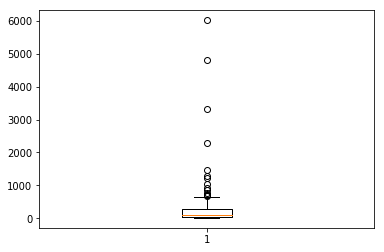

In [191]:
plt.boxplot(x = "total likes",data=nearby_venues)

{'whiskers': [<matplotlib.lines.Line2D at 0x21a4170c710>,
 'caps': [<matplotlib.lines.Line2D at 0x21a417150b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x21a4170c5c0>],
 'medians': [<matplotlib.lines.Line2D at 0x21a41715978>],
 'fliers': [<matplotlib.lines.Line2D at 0x21a41715dd8>],
 'means': []}

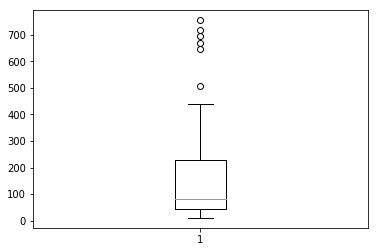

In [192]:
plt.boxplot(x = "total likes",data=nearby_venues[nearby_venues["total likes"]<800])

In [193]:
nearby_venues["total likes"].describe()

count     100.00000
mean      369.74000
std       869.43742
min        10.00000
25%        48.50000
50%        89.00000
75%       287.50000
max      6019.00000
Name: total likes, dtype: float64

To create the categories according to the likes im gonna distribue in a "equivalent way" taking in consideration the statistic informetion above

In [194]:
def conditional_likes(row):
    if row['total likes']<=50:
        return 'Low'
    if row['total likes']<=90:
        return 'Normal'
    if row['total likes']<=300:
        return 'Good'
    if row['total likes']>300:
        return 'Excelent'

nearby_venues['likes_cat']=nearby_venues.apply(conditional_likes, axis=1)

In [195]:
nearby_venues.head()

,name,id,categories,lat,lng,total likes,Sup_Categories,likes_cat
0,Rosi La Loca,5478dde0498eab68d4d6423f,Tapas Restaurant,40.415821,-3.702955,161,restaurant,Good
1,Puerta del Sol,4adcda37f964a5201f3c21e3,Plaza,40.417027,-3.703443,4814,landmarks,Excelent
2,Club del Gourmet Corte Ingles,4bddaac30ee3a59370242eb0,Gourmet Shop,40.417497,-3.704686,71,shop,Normal
3,Bacoa,563b7525cd10e8c24f239bb6,Burger Joint,40.416698,-3.701682,247,restaurant,Good
4,Ferpal,4b8e9fb5f964a520a02c33e3,Restaurant,40.417046,-3.705742,37,restaurant,Low


## Exploratory Data Analysis 

## Venues Map
Its always good to visualize the data, in this project we will just make a Map to see the location of our venues in Madrid and also a couple of graph to see which categories dominates.

In [196]:
# create map of New York using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, categories in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

#### Likes per category
In order to recomend which place select, first im gonna see the distribution of the likes and the number of venues per category

In [198]:
nearby_venues = nearby_venues.dropna()

Text(0.5,1,'Total Likes per Category')

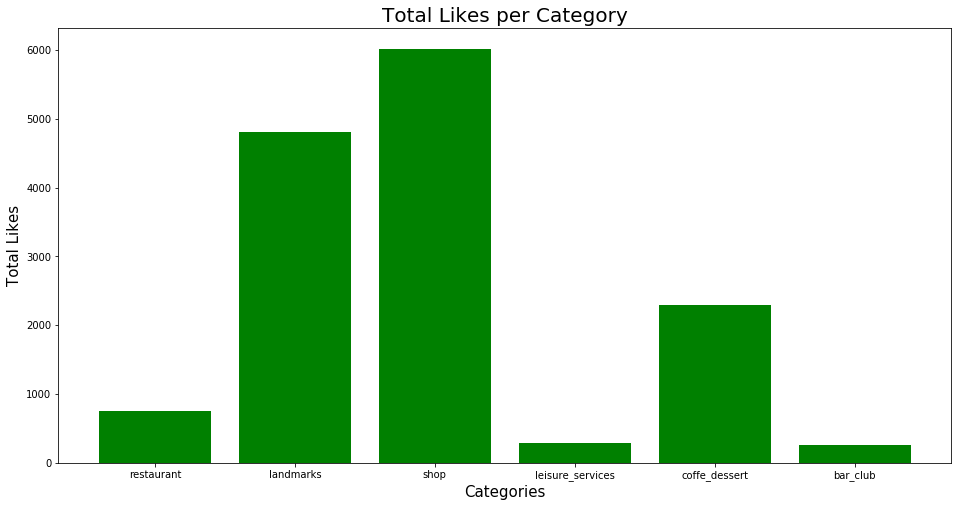

In [199]:
fig = plt.figure(figsize=(16,8))
plt.bar(x="Sup_Categories",height ="total likes", data = nearby_venues, color = "green")
plt.xlabel('Categories', size = 15)
plt.ylabel('Total Likes', size = 15)
plt.title('Total Likes per Category', size = 20)

Text(0.5,1,'Number of venues per category')

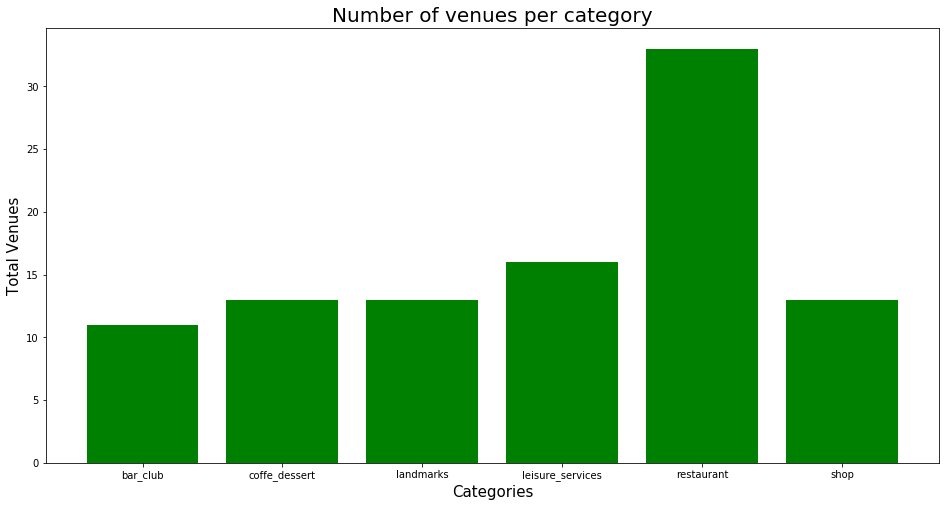

In [200]:
nearby_venues_count = nearby_venues.groupby(["Sup_Categories"]).count().reset_index()
nearby_venues_count
fig = plt.figure(figsize=(16,8))
plt.bar(x="Sup_Categories",height ="id", data = nearby_venues_count, color = "green")
plt.xlabel('Categories', size = 15)
plt.ylabel('Total Venues', size = 15)
plt.title('Number of venues per category', size = 20)

Text(0.5,1,'Number of venues per likes category')

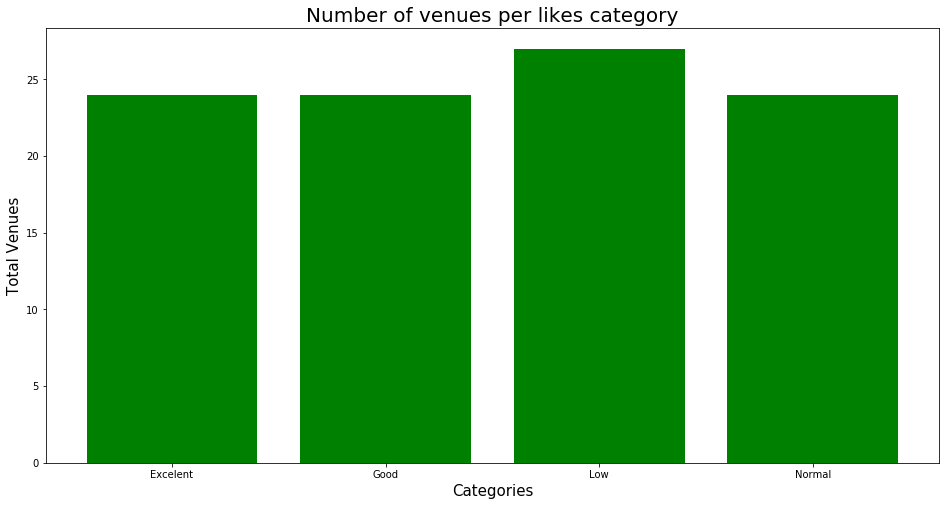

In [202]:
nearby_venues_count = nearby_venues.groupby(["likes_cat"]).count().reset_index()
nearby_venues_count
fig = plt.figure(figsize=(16,8))
plt.bar(x="likes_cat",height ="id", data = nearby_venues_count, color = "green")
plt.xlabel('Categories', size = 15)
plt.ylabel('Total Venues', size = 15)
plt.title('Number of venues per likes category', size = 20)

As we can see shops and landmarks has the higher number of likes even when our API took mainly restaurants as we see in the count plot. We also appreciate that there is quite the same number of Excelent, good, low and normal venues, but this is above the topic because we dont really know the reason of why some venues has a low number of likes, is this because this venues are bad? Or just because they are new. 
Lets see the best places per each category.

In [203]:
best_venues = nearby_venues.groupby("Sup_Categories").max()
best_venues = best_venues[["name","total likes","categories"]]
best_venues

,name,total likes,categories
Sup_Categories,,,
bar_club,Salmon Gurú,255,Wine Bar
coffe_dessert,Zen Zoo,2291,Smoothie Shop
landmarks,Puerta del Sol,4814,Plaza
leisure_services,Way Hostel,286,Theater
restaurant,Ôven Mozzarella Bar,755,Tapas Restaurant
shop,Mercado de San Miguel,6019,Market


In [204]:
best_venues_total = nearby_venues.groupby("Sup_Categories").max()

# create map of New York using latitude and longitude values
map_madrid_best = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, name, categories in zip(best_venues_total['lat'], best_venues_total['lng'], best_venues_total['name'], best_venues_total['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid_best)  
    
map_madrid_best

Now we have a small list which we can use to recommend best places to visit and enjoy in Madrid.

## Cluster
In order to finish the project, i want to do a small machine learning exercice where i divide the venues per cluster and plot a map where we can see the cluster distribution in Madrid.

### Clustering - First Step - Creating Dummy variables for each category

In [205]:
# one hot encoding
nearby_venues_hot = pd.get_dummies(nearby_venues[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nearby_venues_hot['name1'] = nearby_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [nearby_venues_hot.columns[-1]] + list(nearby_venues_hot.columns[:-1])
nearby_venues_hot = nearby_venues_hot[fixed_columns]

nearby_venues_hot.head()

,name1,Argentinian Restaurant,Art Museum,Asian Restaurant,Bar,Beer Bar,Bistro,Bookstore,Burger Joint,Café,Casino,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dumpling Restaurant,Electronics Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Historic Site,History Museum,Hostel,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Jazz Club,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Monument / Landmark,Other Nightlife,Paella Restaurant,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Plaza,Ramen Restaurant,Rental Service,Restaurant,Rock Club,Seafood Restaurant,Smoothie Shop,Spanish Restaurant,Tapas Restaurant,Theater,Wine Bar
0,Rosi La Loca,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Puerta del Sol,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Club del Gourmet Corte Ingles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Bacoa,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Ferpal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [206]:
# one hot encoding
nearby_venues_hot_2 = pd.get_dummies(nearby_venues[['Sup_Categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nearby_venues_hot_2['name2'] = nearby_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [nearby_venues_hot_2.columns[-1]] + list(nearby_venues_hot_2.columns[:-1])
nearby_venues_hot_2 = nearby_venues_hot_2[fixed_columns]

nearby_venues_hot_2.head()

,name2,bar_club,coffe_dessert,landmarks,leisure_services,restaurant,shop
0,Rosi La Loca,0,0,0,0,1,0
1,Puerta del Sol,0,0,1,0,0,0
2,Club del Gourmet Corte Ingles,0,0,0,0,0,1
3,Bacoa,0,0,0,0,1,0
4,Ferpal,0,0,0,0,1,0


In [207]:
# one hot encoding
nearby_venues_hot_3 = pd.get_dummies(nearby_venues[['likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nearby_venues_hot_3['name3'] = nearby_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [nearby_venues_hot_3.columns[-1]] + list(nearby_venues_hot_3.columns[:-1])
nearby_venues_hot_3 = nearby_venues_hot_3[fixed_columns]

nearby_venues_hot_3.head()

,name3,Excelent,Good,Low,Normal
0,Rosi La Loca,0,1,0,0
1,Puerta del Sol,1,0,0,0
2,Club del Gourmet Corte Ingles,0,0,0,1
3,Bacoa,0,1,0,0
4,Ferpal,0,0,1,0


### Clustering - Second Step - Concatenate the dummy variables to our dataframe

In [208]:
nearby_venues_grouped = pd.concat([nearby_venues, nearby_venues_hot,nearby_venues_hot_2,nearby_venues_hot_3], axis=1, join_axes=[nearby_venues.index])
nearby_venues_grouped.head()

,name,id,categories,lat,lng,total likes,Sup_Categories,likes_cat,name1,Argentinian Restaurant,Art Museum,Asian Restaurant,Bar,Beer Bar,Bistro,Bookstore,Burger Joint,Café,Casino,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Cosmetics Shop,Deli / Bodega,Dessert Shop,Dumpling Restaurant,Electronics Store,Gastropub,Gift Shop,Gourmet Shop,Grocery Store,Historic Site,History Museum,Hostel,Hotel,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Jazz Club,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Monument / Landmark,Other Nightlife,Paella Restaurant,Pastry Shop,Performing Arts Venue,Peruvian Restaurant,Plaza,Ramen Restaurant,Rental Service,Restaurant,Rock Club,Seafood Restaurant,Smoothie Shop,Spanish Restaurant,Tapas Restaurant,Theater,Wine Bar,name2,bar_club,coffe_dessert,landmarks,leisure_services,restaurant,shop,name3,Excelent,Good,Low,Normal
0,Rosi La Loca,5478dde0498eab68d4d6423f,Tapas Restaurant,40.415821,-3.702955,161,restaurant,Good,Rosi La Loca,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,Rosi La Loca,0,0,0,0,1,0,Rosi La Loca,0,1,0,0
1,Puerta del Sol,4adcda37f964a5201f3c21e3,Plaza,40.417027,-3.703443,4814,landmarks,Excelent,Puerta del Sol,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,Puerta del Sol,0,0,1,0,0,0,Puerta del Sol,1,0,0,0
2,Club del Gourmet Corte Ingles,4bddaac30ee3a59370242eb0,Gourmet Shop,40.417497,-3.704686,71,shop,Normal,Club del Gourmet Corte Ingles,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Club del Gourmet Corte Ingles,0,0,0,0,0,1,Club del Gourmet Corte Ingles,0,0,0,1
3,Bacoa,563b7525cd10e8c24f239bb6,Burger Joint,40.416698,-3.701682,247,restaurant,Good,Bacoa,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bacoa,0,0,0,0,1,0,Bacoa,0,1,0,0
4,Ferpal,4b8e9fb5f964a520a02c33e3,Restaurant,40.417046,-3.705742,37,restaurant,Low,Ferpal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,Ferpal,0,0,0,0,1,0,Ferpal,0,0,1,0


### Clustering - Third Step - Creating the model with 4 clusters

In [209]:
# set number of clusters
kclusters = 4

nearby_venues_group_clst = nearby_venues_grouped.drop(["name","name1","name2","name3","id","categories",
                                                       "lat","lng","Sup_Categories","likes_cat"],axis=1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nearby_venues_group_clst)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 0, 0, 3, 0, 0, 0, 0])

In [210]:
nearby_venues.insert(0, 'Cluster Labels', kmeans.labels_)

In [211]:
nearby_venues.head(10)

,Cluster Labels,name,id,categories,lat,lng,total likes,Sup_Categories,likes_cat
0,0,Rosi La Loca,5478dde0498eab68d4d6423f,Tapas Restaurant,40.415821,-3.702955,161,restaurant,Good
1,1,Puerta del Sol,4adcda37f964a5201f3c21e3,Plaza,40.417027,-3.703443,4814,landmarks,Excelent
2,0,Club del Gourmet Corte Ingles,4bddaac30ee3a59370242eb0,Gourmet Shop,40.417497,-3.704686,71,shop,Normal
3,0,Bacoa,563b7525cd10e8c24f239bb6,Burger Joint,40.416698,-3.701682,247,restaurant,Good
4,0,Ferpal,4b8e9fb5f964a520a02c33e3,Restaurant,40.417046,-3.705742,37,restaurant,Low
5,3,Apple Puerta del Sol,538a4c78498e264f18c776b2,Electronics Store,40.416804,-3.702221,1290,shop,Excelent
6,0,TOC Hostel,54403f3b498e03786d6ef3bb,Hostel,40.417264,-3.705928,52,leisure_services,Normal
7,0,La Pulpería de Victoria,4f33cbace4b0b5f6dee6d145,Seafood Restaurant,40.416506,-3.701709,128,restaurant,Good
8,0,SunGate Hostel,5476a1ec498eb0f50cb79122,Hostel,40.418696,-3.704623,45,leisure_services,Low
9,0,InClan Brutal Bar,57442b9e498eb4d238e3bece,Tapas Restaurant,40.415023,-3.701864,90,restaurant,Normal


### Clustering - Fourth Step - Plot a map with the clusters and a dataframe per cluster

In [212]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nearby_venues['lat'], nearby_venues['lng'], nearby_venues['name'], nearby_venues['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [213]:
nearby_venues[nearby_venues["Cluster Labels"] == 0]

,Cluster Labels,name,id,categories,lat,lng,total likes,Sup_Categories,likes_cat
0,0,Rosi La Loca,5478dde0498eab68d4d6423f,Tapas Restaurant,40.415821,-3.702955,161,restaurant,Good
2,0,Club del Gourmet Corte Ingles,4bddaac30ee3a59370242eb0,Gourmet Shop,40.417497,-3.704686,71,shop,Normal
3,0,Bacoa,563b7525cd10e8c24f239bb6,Burger Joint,40.416698,-3.701682,247,restaurant,Good
4,0,Ferpal,4b8e9fb5f964a520a02c33e3,Restaurant,40.417046,-3.705742,37,restaurant,Low
6,0,TOC Hostel,54403f3b498e03786d6ef3bb,Hostel,40.417264,-3.705928,52,leisure_services,Normal
7,0,La Pulpería de Victoria,4f33cbace4b0b5f6dee6d145,Seafood Restaurant,40.416506,-3.701709,128,restaurant,Good
8,0,SunGate Hostel,5476a1ec498eb0f50cb79122,Hostel,40.418696,-3.704623,45,leisure_services,Low
9,0,InClan Brutal Bar,57442b9e498eb4d238e3bece,Tapas Restaurant,40.415023,-3.701864,90,restaurant,Normal
10,0,TAKOS,5374c6ff498eb7fa65ba2f4a,Mexican Restaurant,40.418938,-3.703748,326,restaurant,Excelent
11,0,Casa Labra,4adcda34f964a520f73a21e3,Tapas Restaurant,40.417150,-3.704514,438,restaurant,Excelent


In [214]:
nearby_venues[nearby_venues["Cluster Labels"] == 1]

,Cluster Labels,name,id,categories,lat,lng,total likes,Sup_Categories,likes_cat
1,1,Puerta del Sol,4adcda37f964a5201f3c21e3,Plaza,40.417027,-3.703443,4814,landmarks,Excelent
53,1,Mercado de San Miguel,4adcda40f964a5206e3e21e3,Market,40.415443,-3.708943,6019,shop,Excelent


In [215]:
nearby_venues[nearby_venues["Cluster Labels"] == 2]

,Cluster Labels,name,id,categories,lat,lng,total likes,Sup_Categories,likes_cat
23,2,Plaza Mayor,4adcda37f964a520193c21e3,Plaza,40.415451,-3.707268,3325,landmarks,Excelent
31,2,Chocolatería San Ginés,4adcda35f964a5207d3b21e3,Chocolate Shop,40.416754,-3.707079,2291,coffe_dessert,Excelent


In [216]:
nearby_venues[nearby_venues["Cluster Labels"] == 3]

,Cluster Labels,name,id,categories,lat,lng,total likes,Sup_Categories,likes_cat
5,3,Apple Puerta del Sol,538a4c78498e264f18c776b2,Electronics Store,40.416804,-3.702221,1290,shop,Excelent
19,3,Plaza de Santa Ana,4b72841ff964a520db7c2de3,Plaza,40.414631,-3.701033,863,landmarks,Excelent
29,3,Fnac,4adcda3ef964a5204c3e21e3,Electronics Store,40.419176,-3.705269,1217,shop,Excelent
30,3,Gourmet Experience,50accc51e4b03cc0bd939c5a,Gourmet Shop,40.419667,-3.705458,1474,shop,Excelent
40,3,Plaza del Callao,4b59799ff964a520778928e3,Plaza,40.420145,-3.705763,1047,landmarks,Excelent
41,3,La Central de Callao,50340653e0e24113d87d7a88,Bookstore,40.419372,-3.706036,695,shop,Excelent
59,3,Espacio Fundación Telefónica,4b790f5af964a5205fea2ee3,Art Museum,40.420392,-3.701617,671,landmarks,Excelent
71,3,Lamucca de Prado,4cb317c6562d224bce422b88,Restaurant,40.414837,-3.698591,646,restaurant,Excelent
77,3,Botín,4b4e3e50f964a52097e626e3,Spanish Restaurant,40.414019,-3.708136,755,restaurant,Excelent
86,3,Mercado de la Reina,4b2563d4f964a520197124e3,Tapas Restaurant,40.419532,-3.698871,717,restaurant,Excelent
